# Library import

In [1]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
import os
from moviepy.editor import VideoFileClip
from IPython.display import HTML
%matplotlib inline

# Helper functions

In [2]:
def grayscale(img):
    """Applies the Grayscale transform
    This will return an image with only one color channel
    but NOTE: to see the returned image as grayscale
    (assuming your grayscaled image is called 'gray')
    you should call plt.imshow(gray, cmap='gray')"""
    return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Or use BGR2GRAY if you read an image with cv2.imread()
    # return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
def canny(img, low_threshold, high_threshold):
    """Applies the Canny transform"""
    return cv2.Canny(img, low_threshold, high_threshold)

def gaussian_blur(img, kernel_size):
    """Applies a Gaussian Noise kernel"""
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    `vertices` should be a numpy array of integer points.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image


def draw_lines(img, lines, color=[255, 0, 0], thickness=2):
    """
    NOTE: this is the function you might want to use as a starting point once you want to 
    average/extrapolate the line segments you detect to map out the full
    extent of the lane (going from the result shown in raw-lines-example.mp4
    to that shown in P1_example.mp4).  
    
    Think about things like separating line segments by their 
    slope ((y2-y1)/(x2-x1)) to decide which segments are part of the left
    line vs. the right line.  Then, you can average the position of each of 
    the lines and extrapolate to the top and bottom of the lane.
    
    This function draws `lines` with `color` and `thickness`.    
    Lines are drawn on the image inplace (mutates the image).
    If you want to make the lines semi-transparent, think about combining
    this function with the weighted_img() function below
    """
    for line in lines:
        if np.all(line == 0): break
        else:
            for x1,y1,x2,y2 in line:
                cv2.line(img, (x1, y1), (x2, y2), color, thickness)

def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap):
    """
    `img` should be the output of a Canny transform.
        
    Returns an image with hough lines drawn.
    """
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    line_img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
    draw_lines(line_img, lines)
    return line_img

def weighted_img(img, initial_img, α=0.8, β=1., γ=0.):
    """
    `img` is the output of the hough_lines(), An image with lines drawn on it.
    Should be a blank image (all black) with lines drawn on it.
    
    `initial_img` should be the image before any processing.
    
    The result image is computed as follows:
    
    initial_img * α + img * β + γ
    NOTE: initial_img and img must be the same shape!
    """
    return cv2.addWeighted(initial_img, α, img, β, γ)


# Line Functions

In [3]:
def get_line_params(line):
    """ function takes a single line (2 extreme points: x0(line[0,0]), y0(line[0,1]), x1(line[0,2]), y1(line[0,3]))
    and returns the slope and offset as two separate variables (y=mx+b) """
    m = (line[0,3]-line[0,1])/(line[0,2]-line[0,0])
    b = ((line[0,2]*line[0,1]-line[0,0]*line[0,3])/(line[0,2]-line[0,0]))
    return m, b

def calc_line_x_val(m, b, y):
    """" returns the x value of a line at a given y value """
    x = (y - b) / m
    return int(x)

def avg_extrapol(lines):
    """ Separates left (slope<0) and right (slope>0) lanes, then averages and extrapolates left and right lines 
    respectively and returns the extreme values of the two resulting lines. In case of an image / a frame with no
    detected lines, [0, 0, 0, 0] is returned. """
    num_left = 0
    m_left = 0
    b_left = 0
    num_right = 0
    m_right = 0
    b_right = 0
    # initialize min and max values of lines:
    min_y, min_x = image.shape[0:2]
    max_x = max_y = 0
    for line in lines:
        m, b = get_line_params(line)
#         if m < 0: # lines on the left
        if m > -2 and m < -0.5:
            num_left += 1 # increment left line counter
            m_left += m # add slope value to the others as part of averaging
            b_left += b # add offset value to the others as part of averaging
#         elif m > 0: # lines on the right
        elif m > 0.5 and m < 2:
            num_right += 1 # increment right line counter
            m_right += m # add slope value to the others
            b_right += b # add offset value to the others as part of averaging
    if num_left > 0:
        # calculate average slopes and offsets
        m_avg_left = m_left / num_left
        b_avg_left = b_left / num_left
        # determine x extremes
        x_min_left = calc_line_x_val(m_avg_left, b_avg_left, y_min)
        x_max_left = calc_line_x_val(m_avg_left, b_avg_left, y_max)
        # create complete left line
        left_line = [x_min_left, y_min, x_max_left, y_max]
    else:
        print('no left lines detected')
        left_line = [0, 0, 0, 0]
    if num_right > 0:
        # calculate average slopes and offsets:
        m_avg_right = m_right / num_right
        b_avg_right = b_right / num_right
        # determine x extremes
        x_min_right = calc_line_x_val(m_avg_right, b_avg_right, y_min)
        x_max_right = calc_line_x_val(m_avg_right, b_avg_right, y_max)
        # create complete right line
        right_line = [x_min_right, y_min, x_max_right, y_max]
    else:
        print('no right lines detected')
        right_line = [0, 0, 0, 0]
    #return m_avg_left, b_avg_left, m_avg_right, b_avg_right  
    lane_lines = np.array([[left_line, right_line]])
    return lane_lines

---

# Pipeline

The first function `process_image_hough(image)` returns the image with all hough lines drawn on it, whereas the second one `process_image_avg_extrapol(image)` draws only one averaged and extrapolated line per side on the image.

In [4]:
def process_image_hough(image):
    """ Function returns the input image with hough lines as overlays """
    
    # convert into grayscale image
    img_gray = grayscale(image)
    
    # blur image
    gray_blr = gaussian_blur(img_gray, 5)
    
    # apply canny edge detector
    canny_edge = canny(gray_blr, th_low, th_high)
    
    # keep only region of interest
    # (ROI was selected after canny edge detection because otherwise edges are detected at the boundaries of ROI)
    canny_roi = region_of_interest(canny_edge, vertices)
    
    # Probabilistic Hough Line Transform (outputs the extremes of the detected lines)
    lines = cv2.HoughLinesP(canny_roi, rho, theta, threshold, np.array([]), min_line_len, max_line_gap)

    # create black image and draw final lines on it
    image_black = np.zeros((image.shape[0], image.shape[1], 3), dtype=np.uint8)
    draw_lines(image_black, lines, [255, 0, 0], 2)

    # Add black image with final lines and original image
    segments_image = weighted_img(image_black, image, 1, 1, 0)
    
    return segments_image


def process_image_avg_extrapol(image):
    """ Function returns the input image with averaged and extrapolated lane lines as overlays """
    
    # convert into grayscale image
    img_gray = grayscale(image)
    
    # blur image
    gray_blr = gaussian_blur(img_gray, 5)
    
    # apply canny edge detector
    canny_edge = canny(gray_blr, th_low, th_high)
    
    # keep only region of interest
    # (ROI was selected after canny edge detection because otherwise edges are detected at the boundaries of ROI)
    canny_roi = region_of_interest(canny_edge, vertices)
    
    # Probabilistic Hough Line Transform (outputs the extremes of the detected lines)
    lines = cv2.HoughLinesP(canny_roi, rho, theta, threshold, np.array([]), min_line_len, max_line_gap)

    # Add black image with final lines and original image
    image_black = np.zeros((image.shape[0], image.shape[1], 3), dtype=np.uint8)
    draw_lines(image_black, lines, [255, 0, 0], 2)

    # apply averaging and extrapolation to hough lines
    lines_final = avg_extrapol(lines)

    # create black image and draw final lines on it
    image_black = np.zeros((image.shape[0], image.shape[1], 3), dtype=np.uint8)
    draw_lines(image_black, lines_final, [255, 0, 0], 13)

    # Add black image with final lines and original image
    image_final = weighted_img(image_black, image, 1, 1, 0)

    return image_final

---

# Parameter definitions

In [5]:
# find maximum x and y values (all example images have same shape)
image = mpimg.imread('test_images/solidWhiteRight.jpg')
y_max, x_max, _ = image.shape

# Gaussian parameter
kernel_sz = 5

# Canny edge parameters
th_low = 100 #50
th_high = 200 #150

# region of interest (ROI) top y value
y_min = 325 #310

# define length of ROI top (the higher the number the shorter the top region, number must be odd)
top_len_val = 9 #21 # odd number expected
top_left_num = int(top_len_val/2)
top_right_num = int(top_len_val/2)+1

# determine polygon vertices for ROI
top_left = np.array([top_left_num*int(x_max/top_len_val), y_min])
top_right = np.array([top_right_num*int(x_max/top_len_val), y_min])
bottom_left = np.array([0, y_max])
bottom_right = np.array([x_max, y_max])
vertices = np.array([[bottom_left, bottom_right, top_right, top_left]])

# hough transform: ### parameters to detect complete lines only with hough-transform: #threshold = 70 #min_line_len = 100 #max_line_gap = 140
rho = 1
theta = 1 * np.pi/180
threshold = 30
min_line_len = 10
max_line_gap = 30

---

# Finding lines in images

## Example with one image

The pipeline is not used here yet. Instead, all functions are called separateley to show all single steps.

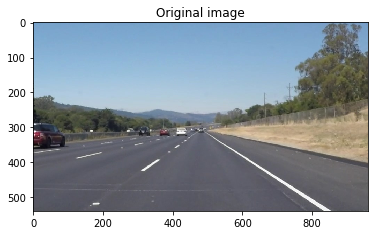

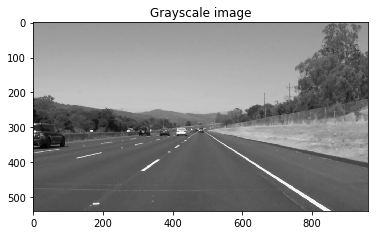

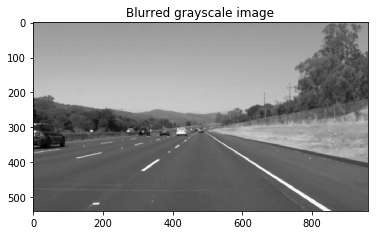

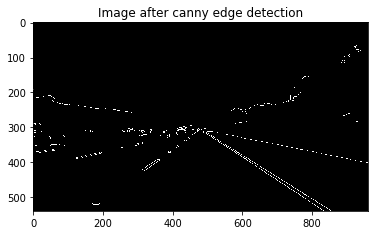

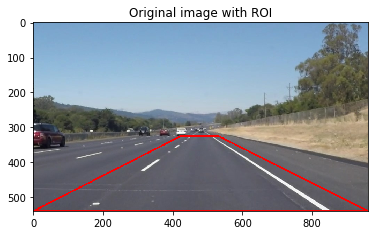

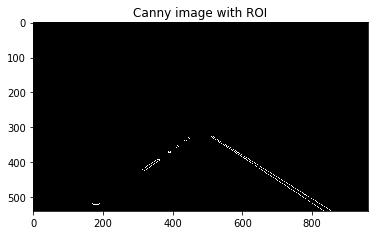

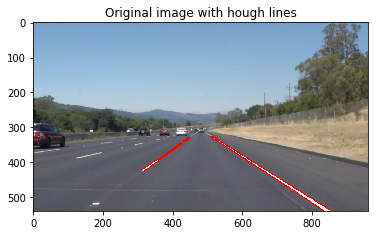

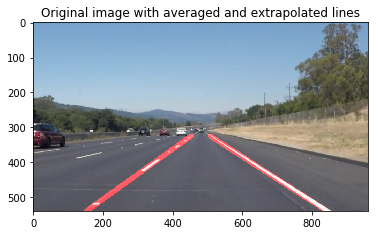

In [6]:
image = mpimg.imread('test_images/solidWhiteRight.jpg')
plt.figure()
plt.imshow(image)
plt.title('Original image')

# convert image into grayscale
img_gray = grayscale(image)
plt.figure()
plt.imshow(img_gray, cmap='gray')
plt.title('Grayscale image')

# blur image
gray_blr = gaussian_blur(img_gray, kernel_sz)
plt.figure()
plt.imshow(gray_blr, cmap='gray')
plt.title('Blurred grayscale image')
plt.imsave('test_images_output/solidWhiteRight_gray_blr.jpg', gray_blr, cmap='gray')

# apply canny edge detector
plt.figure()
canny_edge = canny(gray_blr, th_low, th_high)
plt.imshow(canny_edge, cmap='gray')
plt.title('Image after canny edge detection')
plt.imsave('test_images_output/solidWhiteRight_canny.jpg', canny_edge, cmap='gray')

# visualize ROI
image_roi = np.copy(image)
pts = np.array([[top_left, bottom_left, bottom_left, bottom_right, bottom_right, top_right, top_right, top_left]])
cv2.polylines(image_roi, pts, True, [255, 0, 0], 3)
plt.figure()
plt.imshow(image_roi)
plt.title('Original image with ROI')
plt.imsave('test_images_output/solidWhiteRight_roi.jpg', image_roi)

# Apply ROI on canny edge image
canny_roi = region_of_interest(canny_edge, vertices)
plt.figure()
plt.imshow(canny_roi, cmap='gray')
plt.title('Canny image with ROI')
plt.imsave('test_images_output/solidWhiteRight_canny_roi.jpg', canny_roi, cmap='gray')

# Probabilistic Hough Line Transform (outputs the extremes of the detected lines)
lines = cv2.HoughLinesP(canny_roi, rho, theta, threshold, np.array([]), min_line_len, max_line_gap)
img_hough = np.copy(image) # create copy of original image
draw_lines(img_hough, lines, color=[255, 0, 0], thickness=2) # draws lines on passed image
plt.figure()
plt.imshow(img_hough)
plt.title('Original image with hough lines')
plt.imsave('test_images_output/solidWhiteRight_hough.jpg', img_hough)

# Average and extrapolate lines
lines_final = avg_extrapol(lines)

# create black image and draw final lines on it
image_black = np.zeros((image.shape[0], image.shape[1], 3), dtype=np.uint8)
draw_lines(image_black, lines_final, [255, 0, 0], 13)

# Add black image with final lines and original image
image_copy = np.copy(image) # create copy of original image
final_image = weighted_img(image_black, image_copy, 1, 1, 0)
plt.figure()
plt.imshow(final_image)
plt.title('Original image with averaged and extrapolated lines')
plt.imsave('test_images_output/solidWhiteRight_final_image.jpg',final_image)

### Save images as .pdf if required

In [9]:
plt.imsave('test_images_output/solidWhiteRight_gray.jpg', img_gray, cmap='gray')
plt.imsave('test_images_output/solidWhiteRight_gray_blr.jpg', gray_blr, cmap='gray')
plt.imsave('test_images_output/solidWhiteRight_canny.jpg', canny_edge, cmap='gray')
plt.imsave('test_images_output/solidWhiteRight_roi.jpg', image_roi)
plt.imsave('test_images_output/solidWhiteRight_canny_roi.jpg', canny_roi, cmap='gray')
plt.imsave('test_images_output/solidWhiteRight_hough.jpg', img_hough)
plt.imsave('test_images_output/solidWhiteRight_final_image.jpg',final_image)

## Apply pipeline to all example images

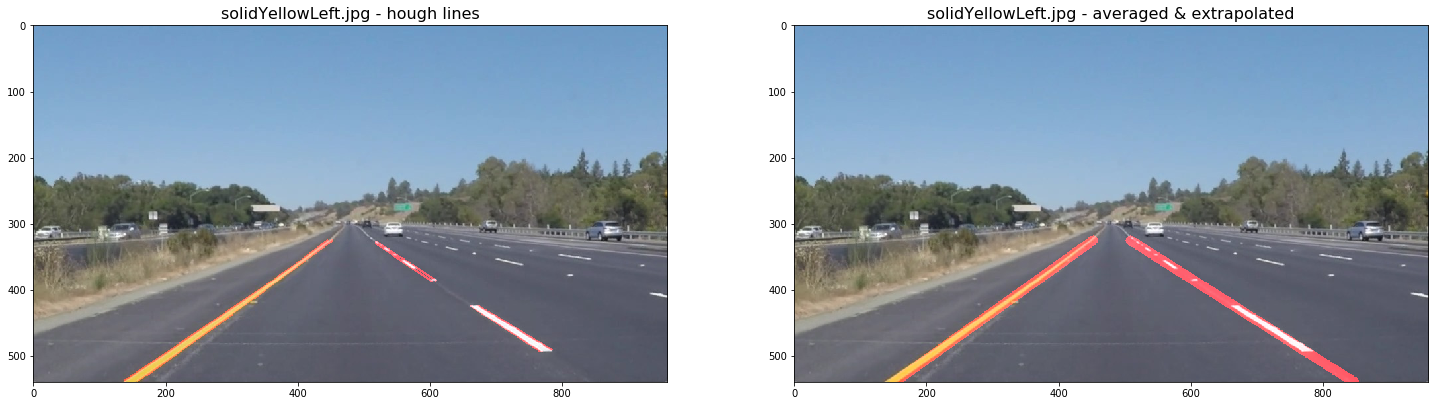

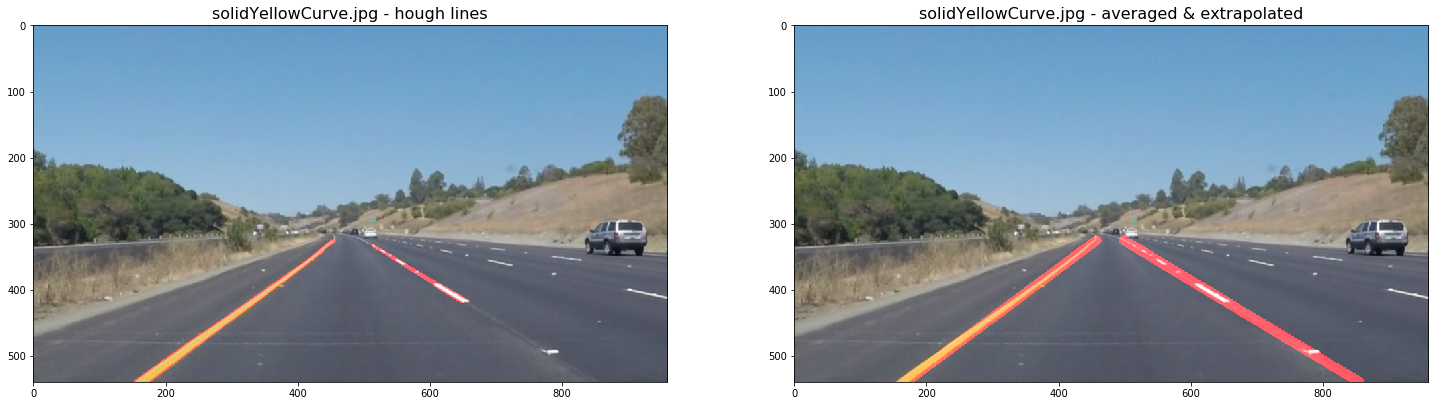

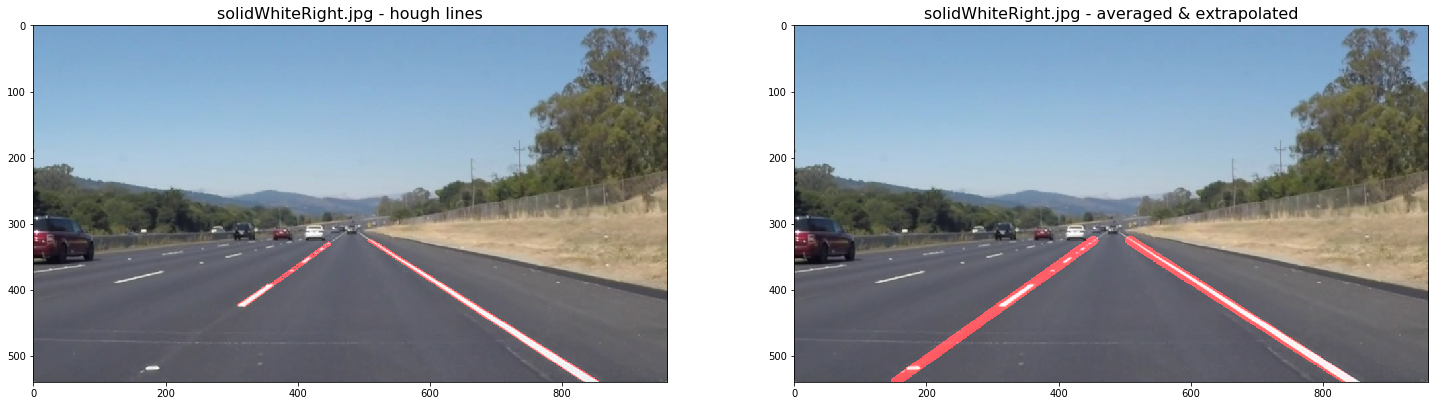

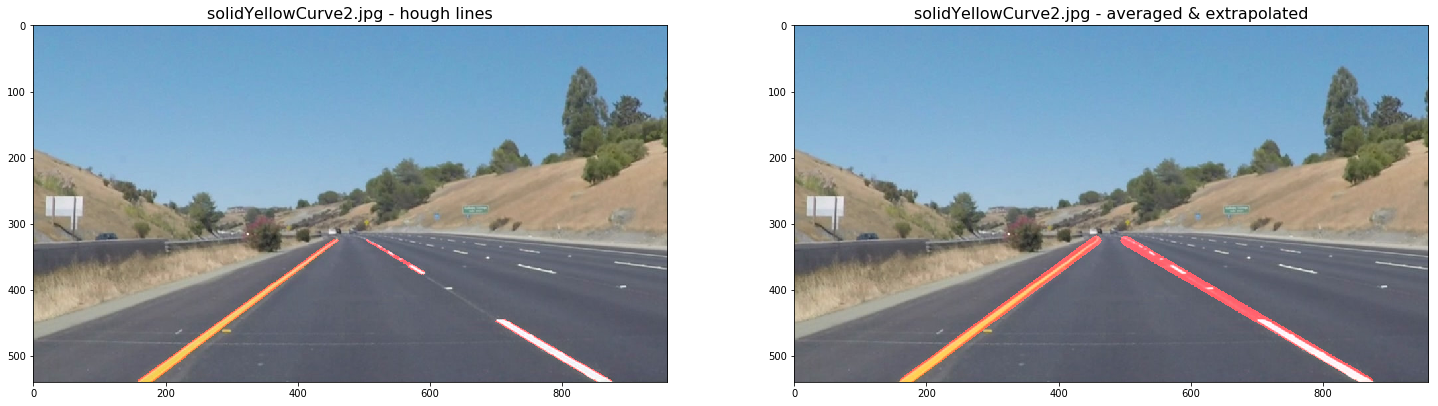

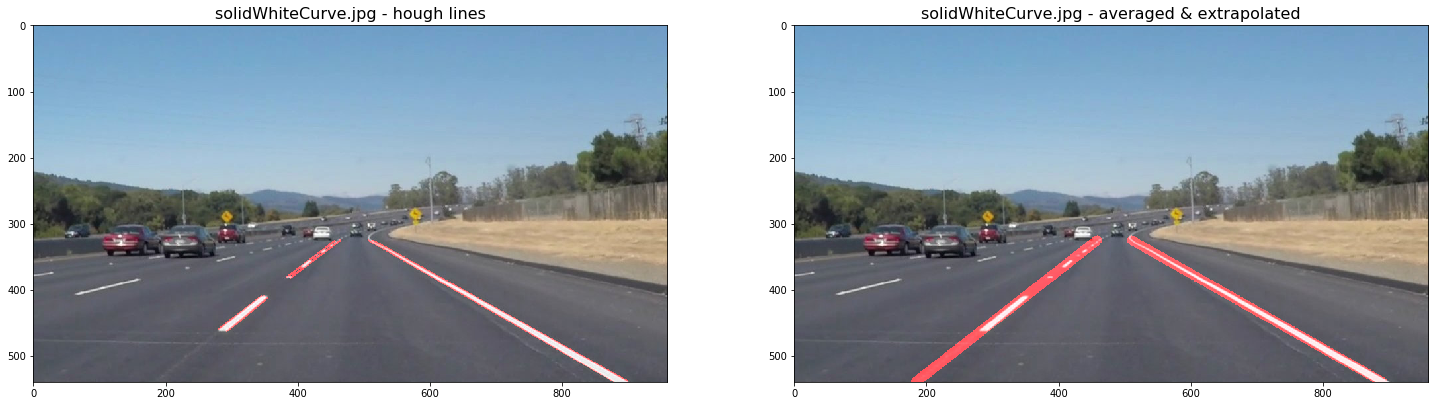

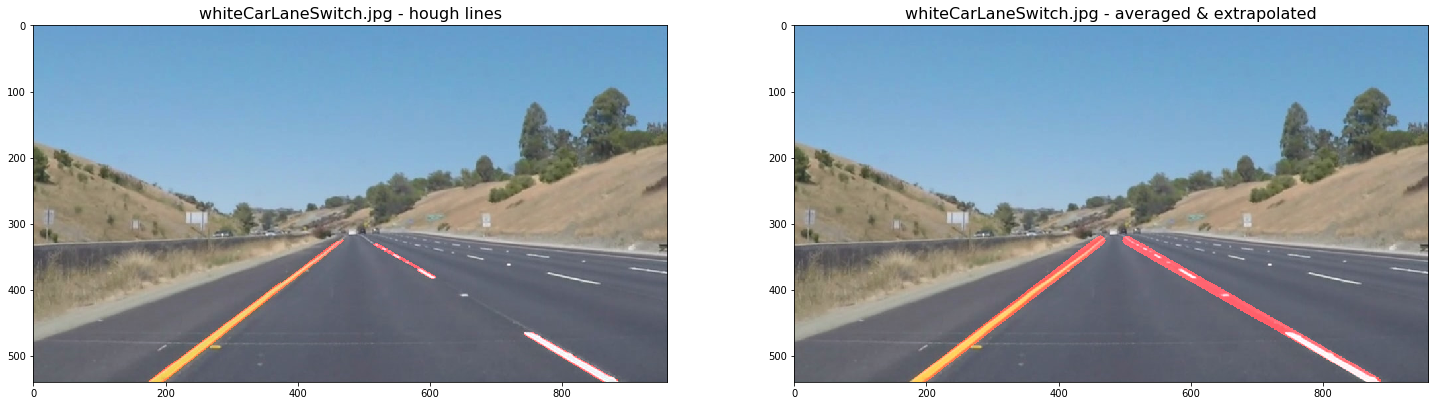

In [10]:
image_names = os.listdir("test_images/")

# set only figure width to keep aspect ratio of subplots
fig_w = 25 # width
fig_h = fig_w/(16/9) # height

for image_name in image_names:
    image = mpimg.imread('test_images/' + image_name)
    
    y_max, x_max, _ = image.shape
    
    # create figure and axes for subplots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(fig_w, fig_h))
    
    segments_image = process_image_hough(image)
    ax1.imshow(segments_image)
    ax1.set_title(image_name + ' - hough lines', fontsize = 16)

    image_final = process_image_avg_extrapol(image)
    ax2.imshow(image_final)
    ax2.set_title(image_name + ' - averaged & extrapolated', fontsize = 16)
    fig.savefig('test_images_output/processed_' + image_name) # save images in subplots

---

# Finding lanes in videos

In [11]:
white_output = 'test_videos_output/solidWhiteRight.mp4'
#clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4").subclip(0,5)
clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4")
white_clip = clip1.fl_image(process_image_avg_extrapol) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

[MoviePy] >>>> Building video test_videos_output/solidWhiteRight.mp4
[MoviePy] Writing video test_videos_output/solidWhiteRight.mp4


100%|█████████▉| 221/222 [00:13<00:00, 15.82it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/solidWhiteRight.mp4 

CPU times: user 2.99 s, sys: 285 ms, total: 3.28 s
Wall time: 15.8 s


In [12]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))

In [13]:
# create .gif
gif_clip1 = (VideoFileClip("test_videos_output/solidWhiteRight.mp4" ) .resize(0.5))
gif_clip1.write_gif('test_videos_output/solidWhiteRight.gif')


[MoviePy] Building file test_videos_output/solidWhiteRight.gif with imageio


100%|█████████▉| 221/222 [00:15<00:00, 14.05it/s]


In [14]:
yellow_output = 'test_videos_output/solidYellowLeft.mp4'
##clip2 = VideoFileClip('test_videos/solidYellowLeft.mp4').subclip(0,5)
clip2 = VideoFileClip('test_videos/solidYellowLeft.mp4')
yellow_clip = clip2.fl_image(process_image_avg_extrapol)
%time yellow_clip.write_videofile(yellow_output, audio=False)

[MoviePy] >>>> Building video test_videos_output/solidYellowLeft.mp4
[MoviePy] Writing video test_videos_output/solidYellowLeft.mp4


100%|█████████▉| 681/682 [00:47<00:00, 13.99it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/solidYellowLeft.mp4 

CPU times: user 9.37 s, sys: 734 ms, total: 10.1 s
Wall time: 48.9 s


In [15]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(yellow_output))

In [16]:
# create .gif
gif_clip2 = (VideoFileClip("test_videos_output/solidYellowLeft.mp4" ) .resize(0.5))
gif_clip2.write_gif('test_videos_output/solidYellowLeft.gif')


[MoviePy] Building file test_videos_output/solidYellowLeft.gif with imageio


100%|█████████▉| 681/682 [00:46<00:00, 14.52it/s]


## Optional Challenge

Try your lane finding pipeline on the video below.  Does it still work?  Can you figure out a way to make it more robust?  If you're up for the challenge, modify your pipeline so it works with this video and submit it along with the rest of your project!

In [17]:
# get frame height and width
challenge_path = 'test_videos/challenge.mp4'
video = cv2.VideoCapture(challenge_path)
y_max = int(video.get(cv2.CAP_PROP_FRAME_HEIGHT))
x_max = int(video.get(cv2.CAP_PROP_FRAME_WIDTH))

# determine relative roi top y point
y_min = int(y_max/(540/325))

# determine polygon vertices for relative roi top y point
top_left = np.array([top_left_num*int(x_max/top_len_val), y_min])
top_right = np.array([top_right_num*int(x_max/top_len_val), y_min])
bottom_left = np.array([0, y_max])
bottom_right = np.array([x_max, y_max])
vertices = np.array([[bottom_left, bottom_right, top_right, top_left]])

In [20]:
challenge_output = 'test_videos_output/challenge.mp4'
##clip3 = VideoFileClip('test_videos/challenge.mp4').subclip(0,5)
clip3 = VideoFileClip('test_videos/challenge.mp4')
challenge_clip = clip3.fl_image(process_image_avg_extrapol)
%time challenge_clip.write_videofile(challenge_output, audio=False)

[MoviePy] >>>> Building video test_videos_output/challenge.mp4
[MoviePy] Writing video test_videos_output/challenge.mp4


 39%|███▉      | 99/251 [00:10<00:21,  6.96it/s]

no right lines detected
no right lines detected


 43%|████▎     | 108/251 [00:11<00:19,  7.18it/s]

no left lines detected
no left lines detected


 43%|████▎     | 109/251 [00:11<00:19,  7.12it/s]

no left lines detected
no left lines detected


 44%|████▍     | 111/251 [00:11<00:19,  7.03it/s]

no left lines detected
no left lines detected


 45%|████▌     | 113/251 [00:12<00:20,  6.73it/s]

no left lines detected
no left lines detected


 46%|████▌     | 115/251 [00:12<00:20,  6.71it/s]

no left lines detected
no left lines detected


 47%|████▋     | 117/251 [00:12<00:20,  6.59it/s]

no left lines detected
no left lines detected


 47%|████▋     | 119/251 [00:12<00:19,  6.66it/s]

no left lines detected
no left lines detected


 48%|████▊     | 121/251 [00:13<00:20,  6.39it/s]

no left lines detected
no left lines detected


 49%|████▉     | 123/251 [00:13<00:20,  6.39it/s]

no left lines detected
no left lines detected


 50%|████▉     | 125/251 [00:13<00:19,  6.33it/s]

no left lines detected
no left lines detected


 51%|█████     | 127/251 [00:14<00:21,  5.72it/s]

no left lines detected
no left lines detected


 51%|█████▏    | 129/251 [00:14<00:20,  5.85it/s]

no left lines detected
no left lines detected


 52%|█████▏    | 131/251 [00:14<00:19,  6.17it/s]

no left lines detected
no left lines detected


 53%|█████▎    | 133/251 [00:15<00:19,  6.12it/s]

no left lines detected
no left lines detected


 54%|█████▍    | 135/251 [00:15<00:18,  6.18it/s]

no left lines detected
no left lines detected


 55%|█████▍    | 137/251 [00:15<00:17,  6.58it/s]

no left lines detected


 55%|█████▌    | 139/251 [00:16<00:17,  6.24it/s]

no left lines detected


100%|██████████| 251/251 [00:33<00:00,  7.21it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/challenge.mp4 

CPU times: user 6.26 s, sys: 471 ms, total: 6.73 s
Wall time: 37.5 s


In [21]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(challenge_output))